# LLM Judgment - Human Judgment as a Target

This experiments applied the signed differecnes of LLM labels and human labels as a target for analysis the features.

In [1]:
import pandas as pd
import glob
import statsmodels.api as sm

In [10]:
# Load each text file into a DataFrame
qrel_human_df = pd.read_csv('./qrels/2023.qrels.pass.withDupes.txt', delimiter=' ', header=None, names=['qid', 'Q0', 'docid', 'label'])  # adjust delimiter if necessary
qrel_llm_df = pd.read_csv('./qrels/2023.qrels.pass.gpt4.txt', delimiter=' ', header=None, names=['qid', 'Q0', 'docid', 'label'])

# Merge the two DataFrames based on a common column, e.g., 'id'
qrels_df = pd.merge(qrel_human_df, qrel_llm_df, on=['qid', 'docid'])

qrels_df.drop(['Q0_x'], axis=1, inplace=True)
qrels_df.drop(['Q0_y'], axis=1, inplace=True)

qrels_df.rename(columns={'label_x': 'label_human'}, inplace=True)
qrels_df.rename(columns={'label_y': 'label_llm'}, inplace=True)

qrels_df['llm_human_diff'] = qrels_df['label_llm'] - qrels_df['label_human']

# Display or save the merged DataFrame
# print(qrels_df['llm-human'])

In [11]:
queries_judged = set(qrels_df['qid'])
real_queries_judged = [x for x in queries_judged if x < 3000000]
t5_queries_judged = [x for x in queries_judged if x > 3000000 and x < 3100000]
gpt4_queries_judged = [x for x in queries_judged if x > 3100000]

In [12]:
qid_to_info = pd.read_csv("infos/query_to_info.txt", sep='\t')
doc_to_info = pd.read_csv("infos/doc_to_info.txt", sep='\t')

In [13]:
data = pd.merge(qrels_df, qid_to_info, on='qid')
data = pd.merge(data, doc_to_info, on='docid')

In [6]:
data.head(20)
#data.describe

,qid,docid,label_human,label_llm,llm_human_diff,QL,QDR,QDS,QW,DL,isSynthetic,isGPT4,DW
0,2001010,msmarco_passage_00_257661787,0,0,0,0,0.784,0.7023,6,72.5291,0,0,56
1,2001010,msmarco_passage_00_257662430,0,0,0,0,0.784,0.7023,6,72.5291,0,0,43
2,2001010,msmarco_passage_00_257664103,0,0,0,0,0.784,0.7023,6,72.5291,0,0,46
3,2001010,msmarco_passage_00_729310942,0,1,1,0,0.784,0.7023,6,72.5291,0,0,47
4,2001010,msmarco_passage_00_729315698,1,1,0,0,0.784,0.7023,6,72.5291,0,0,45
5,2001010,msmarco_passage_00_729382608,1,0,1,0,0.784,0.7023,6,72.5291,0,0,53
6,2001010,msmarco_passage_00_729386217,1,0,1,0,0.784,0.7023,6,72.5291,0,0,55
7,2001010,msmarco_passage_00_729411995,1,2,1,0,0.784,0.7023,6,72.5291,0,0,59
8,2001010,msmarco_passage_00_729434403,1,0,1,0,0.784,0.7023,6,72.5291,0,0,66
9,2001010,msmarco_passage_01_221183941,0,0,0,0,0.784,0.7023,6,72.5291,0,0,66


In [7]:
mixed_model = "llm_human_diff ~ QL + QW + isSynthetic + DW"

In [8]:
## Function to check model assumptions 
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_residuals(result):
    
    # Extract residuals and fitted values
    residuals = result.resid
    fitted_values = result.fittedvalues

    # Q-Q plot
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, edgecolor='k')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Residuals vs. Fitted values
    plt.figure(figsize=(8, 6))
    plt.scatter(fitted_values, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

In [19]:
#import statsmodels.formula.api as smf
model = sm.MixedLM.from_formula(mixed_model, data, groups=data["docid"])
#model = sm.OLS.from_formula(mixed_model, data)
#model = smf.logit(formula = mixed_model, data= data)

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: llm_human_diff
No. Observations: 24249   Method:             REML          
No. Groups:       21873   Scale:              0.3932        
Min. group size:  1       Log-Likelihood:     -31733.2608   
Max. group size:  324     Converged:          Yes           
Mean group size:  1.1                                       
-------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept    -0.018     0.021   -0.876  0.381  -0.059   0.023
QL           -0.298     0.026  -11.286  0.000  -0.350  -0.246
QW            0.057     0.003   16.392  0.000   0.050   0.064
isSynthetic  -0.089     0.014   -6.554  0.000  -0.115  -0.062
DW           -0.000     0.000   -1.869  0.062  -0.000   0.000
Group Var     0.457     0.040                                
============================================================

"""

AttributeError: 'MixedLM' object has no attribute 'weights'

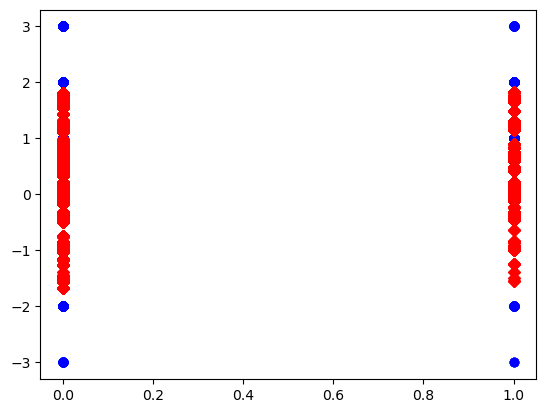

In [26]:
fig = sm.graphics.plot_fit(result, "QL")
fig.tight_layout(pad=1.0)

<function matplotlib.pyplot.close(fig=None)>

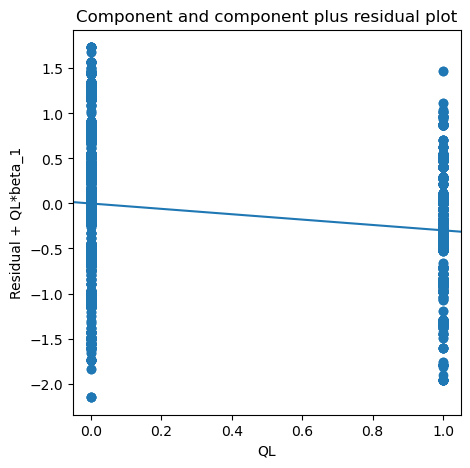

In [24]:
# Component-Component plus Residual (CCPR) Plots (= partial residual plot)
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result, 'QL', ax=ax)
plt.close

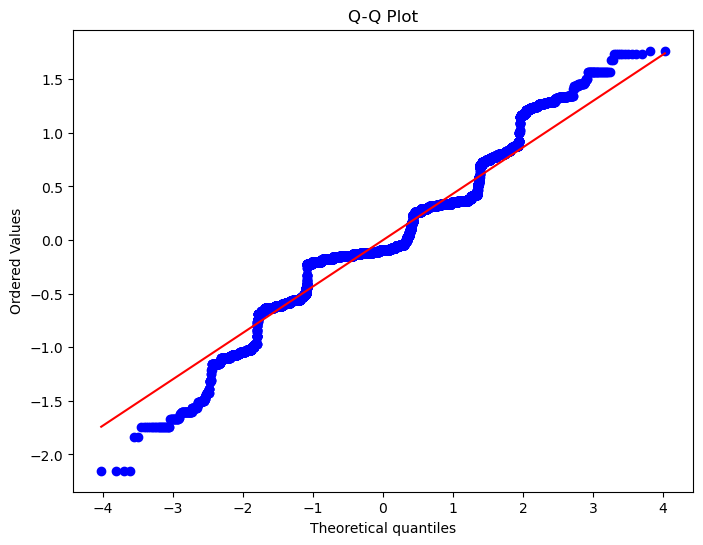

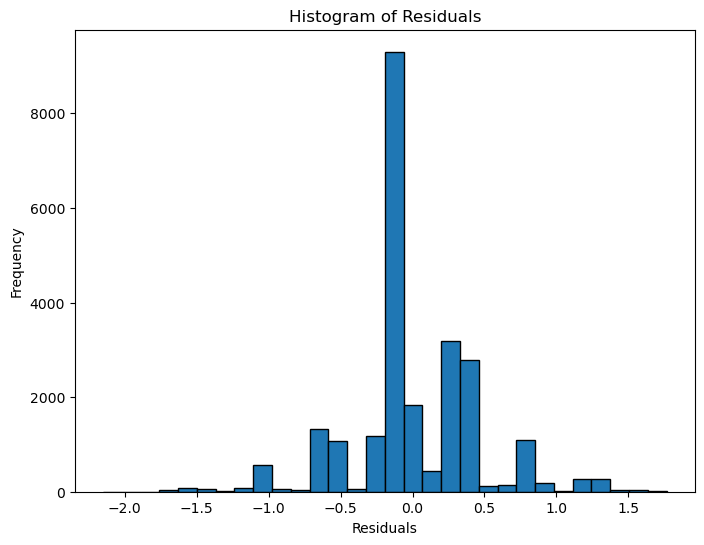

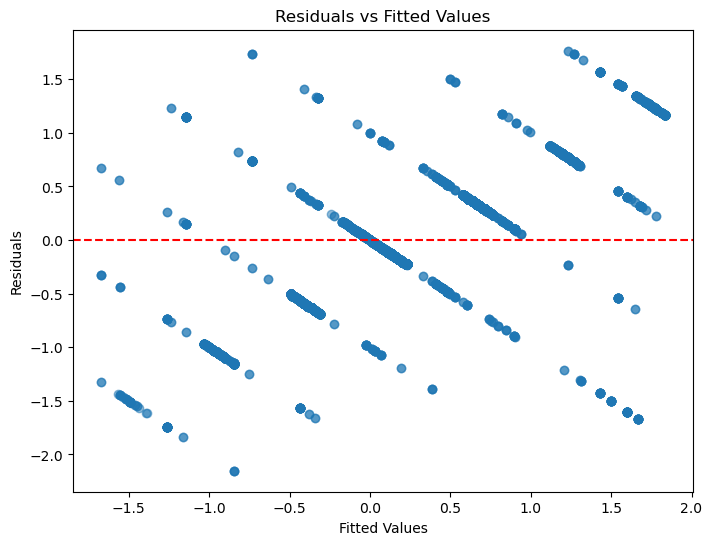

In [17]:
plot_residuals(result)

In [35]:
mixed_model_int = "score ~ isGPT4 + Judge + QL + QDR + QW + C(LLM, Treatment(reference='Other')) + C(Judge, Treatment(reference='nist')) * C(LLM, Treatment(reference='Other')) + isGPT4 * C(LLM, Treatment(reference='Other')) + pipeline"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_int, data, groups=data["run_id"])
result = model.fit()
result.summary()

In [11]:
real_queries_real_judgments = data[((data['Judge'] == 'nist') & (data['qid'].isin(real_queries_judged)))]
synthetic_queries_real_judgments = data[((data['Judge'] == 'nist') & (data['qid'].isin(t5_queries_judged) | data['qid'].isin(gpt4_queries_judged)))]

In [12]:
real_queries_synthetic_judgments = data[((data['Judge'] == 'gpt4') & (data['qid'].isin(real_queries_judged)))]
synthetic_queries_synthetic_judgments = data[((data['Judge'] == 'gpt4') & (data['qid'].isin(t5_queries_judged) | data['qid'].isin(gpt4_queries_judged)))]

In [13]:
mixed_model_condition_Qreal = "score ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline"
mixed_model_condition_Qsynthetic = "score ~ QL + QDS + QW + C(LLM, Treatment(reference='Other')) + pipeline"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qreal, real_queries_real_judgments, groups=real_queries_real_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qsynthetic, synthetic_queries_real_judgments, groups=synthetic_queries_real_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qreal, real_queries_synthetic_judgments, groups=real_queries_synthetic_judgments["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_condition_Qsynthetic, synthetic_queries_synthetic_judgments, groups=synthetic_queries_synthetic_judgments["run_id"])
result = model.fit()
result.summary()

In [18]:
# Merging the dataframes on 'run_id' and 'qid'
real_queries_diff = pd.merge(real_queries_real_judgments, real_queries_synthetic_judgments[['run_id', 'qid', 'score']], on=['run_id', 'qid'], suffixes=('_a', '_b'))
# Subtracting the 'Score' values
real_queries_diff['score_ab'] = real_queries_diff['score_a'] - real_queries_diff['score_b']
real_queries_diff['score_ba'] = real_queries_diff['score_b'] - real_queries_diff['score_a']

In [ ]:
real_queries_diff

In [ ]:
model = sm.MixedLM.from_formula("score_ab ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", real_queries_diff, groups=real_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula("score_ba ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", real_queries_diff, groups=real_queries_diff["run_id"])
result = model.fit()
result.summary()

In [21]:
# Merging the dataframes on 'run_id' and 'qid'
synthetic_queries_diff = pd.merge(synthetic_queries_real_judgments, synthetic_queries_synthetic_judgments[['run_id', 'qid', 'score']], on=['run_id', 'qid'], suffixes=('_a', '_b'))
# Subtracting the 'Score' values
synthetic_queries_diff['score_ab'] = synthetic_queries_diff['score_a'] - synthetic_queries_diff['score_b']
synthetic_queries_diff['score_ba'] = synthetic_queries_diff['score_b'] - synthetic_queries_diff['score_a']

In [ ]:
synthetic_queries_diff

In [ ]:
model = sm.MixedLM.from_formula("score_ab ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", synthetic_queries_diff, groups=synthetic_queries_diff["run_id"])
result = model.fit()
result.summary()

In [ ]:
model = sm.MixedLM.from_formula("score_ba ~ QL + QDR + QW + C(LLM, Treatment(reference='Other')) + pipeline", synthetic_queries_diff, groups=synthetic_queries_diff["run_id"])
result = model.fit()
result.summary()

## Extra Experiments (refer to: "Extra Exp. 1")

In [6]:
def get_result(result_file):
    result_df = pd.read_csv(result_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
    result_df = result_df[result_df['qid'] != 'all']
    result_df['score'] = result_df['score'].astype(float)
    result_df['qid'] = result_df['qid'].astype(int)
    result_df['metric'] = result_df['metric'].apply(lambda x: x.rstrip())
    result_df = result_df[(result_df['metric'] == metric)]
    result_df.drop(['metric'], axis=1, inplace=True)
    return result_df

In [7]:
real_judge_results = get_result(result_file="results/all.pass.nist.ndcgeval")
synthetic_judge_results = get_result(result_file="results/all.pass.gpt4.ndcgeval")

In [9]:
# Merging the dataframes on 'run_id' and 'qid'
results_diff = pd.merge(real_judge_results, synthetic_judge_results, on=['run_id', 'qid'], suffixes=('_real', '_synthetic'))
# Subtracting the 'Score' values
results_diff['score_RS'] = results_diff['score_real'] - results_diff['score_synthetic']
results_diff['score_SR'] = results_diff['score_synthetic'] - results_diff['score_real']

In [13]:
results_diff = pd.merge(results_diff, qid_to_info, on='qid')
results_diff = pd.merge(results_diff, model_to_info, on='run_id')

In [ ]:
results_diff

Selected: score_SR

In [17]:
results_diff['qd_RS'] = results_diff['QDR'] - results_diff['QDS']
results_diff['qd_SR'] = results_diff['QDS'] - results_diff['QDR']

In [21]:
mixed_model_1 = "score_SR ~ Synthetic + QL + qd_SR + QW + DL + pipeline + C(LLM, Treatment(reference='Other')) + Synthetic * C(LLM, Treatment(reference='Other'))"

In [ ]:
model = sm.MixedLM.from_formula(mixed_model_1, results_diff, groups=results_diff["run_id"])
result = model.fit()
result.summary()